<center> <h2> DISCO GAN </h2> </center>

In May 2017, Taeksoo Kim & al. published a way to learn discover domain relation with Generative Adversial Networks: 
https://arxiv.org/pdf/1703.05192.pdf . Let's try to implement this nice paper and get nice results.

## 1. DiscoGAN Architecture ##

<h4> 1st architecture : </h4>

The initial idea is to used a standard GAN architecture to transform picture from one domain to another. 

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./gan1.png",width=500, height=250)

Unfortunately the equality GBA ◦ GAB(xA) = xA should be satisfied, but this hard constraint is difficult to optimize. For this reason, we minimize the distance d(GBA ◦ GAB(xA),xA), where any form of metric function (L1, L2, Huber loss) can be used. 

<h4> 2nd architecture : </h4>

In [3]:
Image(url= "./gan2.png",width=500, height=250)

As the application must be bijective between domain A to domain B, we also need tov minimized(GAB ◦GBA(xB),xB):

<h4> 3rd architecture : </h4>

In [4]:
Image(url= "./gan3.png",width=500, height=250)

This is the model exposed in the paper. We hence have 2 generators ($G_{AB}$ and $G_{BA}$), and two discriminators $D_A$ and $D_B$.

## 2. Implementation ##


Let's build the generators. Compared to standard GAN, the generators here take a picture as input instead of random Gaussian noise z. Each generator is composed of an encoder and a decoder. The official paper implementation mentions 4 conv2 layer followed by 4 ConvTranspose2d layers, use leakyrelu for the encoder part et Relu for decoder part. What is interesting here is the latent space representation between the encoder and the decoder.

<h4> Different imports : </h4>

In [4]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.backend import resize_images
from keras.initializers import RandomNormal
from keras.optimizers import Adam,RMSprop
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Using TensorFlow backend.


In [5]:
def generator():
        
    # Image input
    input_pic = (128, 128,3)
    
    model = Sequential()

    # Decoder ######
    # d1 :
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic))
    model.add(LeakyReLU(alpha=0.2)) #output shape 64, 64 , 64 
    
    # d2 :
    model.add(Conv2D(filters=64*2, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic))
    model.add(InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2)) #output shape 32, 32 , 128 
    
    # d3 :
    model.add(Conv2D(filters=64*4, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic))
    model.add(InstanceNormalization()) 
    model.add(LeakyReLU(alpha=0.2)) #output shape 16, 16 ,256 
    
    # d4 :
    model.add(Conv2D(filters=64*8, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic))
    model.add(InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))  #output shape 8, 8 , 512 
    
    # d5 :
    model.add(Conv2D(filters=64*8, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic))
    model.add(InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))  #output shape 4, 4 , 512 
    
    # d6 :
    model.add(Conv2D(filters=64*8, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic))
    model.add(InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))  #output shape 2, 2 , 512     
    
    # d7 :
    model.add(Conv2D(filters=64*8, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic))
    model.add(InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))  #output shape 1, 1 , 512     
    
    
    # Encoder ######
    model.add(Conv2DTranspose(filters=64*8, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(Activation('relu'))   #output shape 2, 2 , 512 
    
    model.add(Conv2DTranspose(filters=64*8, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(Activation('relu'))   #output shape 4, 4 , 512 
    
    model.add(Conv2DTranspose(filters=64*8, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(Activation('relu'))   #output shape 8, 8 , 512 
    
    model.add(Conv2DTranspose(filters=64*4, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(Activation('relu'))  #output shape 16, 16 , 256 
    
    model.add(Conv2DTranspose(filters=64*2, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(Activation('relu')) #output shape 32, 32 , 128
    
    model.add(Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(Activation('relu')) #output shape 64, 64 , 64
    
    model.add(Conv2DTranspose(filters=3, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(Activation('tanh')) #output shape 128, 128 , 3 
    
    return model

a = generator()
print(a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization_1 (In (None, 32, 32, 128)       2         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       524544    
_________________________________________________________________
instance_normalization_2 (In (None, 16, 16, 256)       2         
__________

In [6]:
def discriminator():
    
    in_shape = (128, 128,3)
    
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2,2), padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(filters=64*2, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(filters=64*4, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(filters=64*8, kernel_size=(4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(filters=1, kernel_size=(4, 4), strides=(1,1), padding='same'))

    return model

b = discriminator()
print(b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization_14 (I (None, 32, 32, 128)       2         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       524544    
_________________________________________________________________
instance_normalization_15 (I (None, 16, 16, 256)       2         
__________

## 3. Train ##
### 3.1 Single iteration ###

Let's train the model on only one batch, just to make things clear. We are going to use the edge to shoes dataset for now.

This data set can be downloaded here : https://www.kaggle.com/vikramtiwari/pix2pix-dataset

Picture inside shoes dataset are 512x256 with both edge and full picture. We need first to dissociate this picture in two pictures of size 128x128.

In [8]:
def read_picture(filename,img_out_size= 128):
    image = cv2.imread(filename)
    
    if image is None:
        assert("error reading picture")
    
    imageA = image[:, :256, :]
    imageB = image[:, 256:, :]

    imageA = cv2.resize(imageA, (img_out_size,img_out_size))
    imageB = cv2.resize(imageB, (img_out_size,img_out_size))
    
    return imageA,imageB

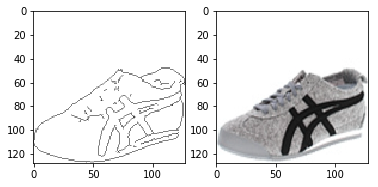

In [9]:
X,Y = read_picture('datasets/edges2shoes/train/605_AB.jpg')

plt.subplot(1, 2, 1)
plt.imshow(X)
plt.subplot(1, 2, 2)
plt.imshow(Y)

We will also need to normalize the pictures for the training. It will be between [0 1]. 

In [10]:
def normalize_picture(img):
    # The data is currently in a range [0, 255].
    # Transform data to have a range [0, 1].
    img = img / 127.5 - 1
    return img

In [11]:
X = normalize_picture(X)
Y = normalize_picture(Y)

Ok, we have two picture, one from domain A, and one from domain B. We need a function that will create the batch:

In [12]:
def batch_creation(batch_size,batch_idx):
    # get 64 pictures from the files
    process_batchA = []
    process_batchB = []
    current_pic = data[batch_idx*batch_size:batch_idx*batch_size+batch_size]
    
    #print(current_pic)
    # call read picture
    for i in range(len(current_pic)):
        filename = os.path.join(image_paths, current_pic[i])
        A,B = read_picture(filename)
        # normalize picture
        A = normalize_picture(A)
        B = normalize_picture(B)
        #append 2 pic in a list
        process_batchA.append(A)
        process_batchB.append(B)
    
    return process_batchA, process_batchB

In [13]:
import os,fnmatch

image_paths = "./datasets/edges2shoes/train"
data = fnmatch.filter(os.listdir(image_paths), '*.jpg')
        
batch_size = 64
batchA, batchB = batch_creation(batch_size,0)
batchA = np.asarray(batchA)
batchB = np.asarray(batchB)
print(batchA.shape)
print(len(data))

(64, 128, 128, 3)
49825


Let's create and compile dicriminators and generators:

In [14]:
disc_optimizer = Adam(lr=0.0002, beta_1=0.5)

discriA = discriminator()
discriB = discriminator()
discriA.compile(loss='mse',optimizer=disc_optimizer,metrics=['accuracy'])
discriB.compile(loss='mse',optimizer=disc_optimizer,metrics=['accuracy'])

Create combined model for generator:

In [15]:
gen_AB = generator()
gen_BA = generator()

# Input images(real)
img_A = Input((128,128,3))
img_B = Input((128,128,3))

# Translate images to the other domain
fake_B = gen_AB(img_A)
fake_A = gen_BA(img_B)

# back to original domain
back_A = gen_BA(fake_B)
back_B = gen_AB(fake_A)

# For the combined model we will only train the generators
discriA.trainable = False
discriB.trainable = False

# Discriminators determines validity of translated images
valid_A = discriA(fake_A)
valid_B = discriB(fake_B)

combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        fake_B, fake_A,
                                        back_A, back_B ])
combined.compile(loss=['mse', 'mse',
                            'mae', 'mae',
                            'mae', 'mae'],
                      optimizer=disc_optimizer)

combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 128, 128, 3)  30681501    input_2[0][0]                    
                                                                 sequential_5[1][0]               
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 128, 128, 3)  30681501    input_1[0][0]                    
          

In [16]:
# Adversarial loss ground truths
# We use this since our discriminator output is a (8,8,1)
# and this discriminator is called PatchGAN.

#Actually, Its like dividing the full picture to different parts ( 8 x 8) and then make the prediction if its real
#or fake for the different parts, and then take the mean.

patch = int(128 / 2**4)
d_patch = (patch, patch, 1)

valid = np.ones((batch_size,) + d_patch)
fake = np.zeros((batch_size,) + d_patch)
# valid shape is ( batchsize, 8 , 8 , 1 ) and all of them are ones.
# same for fake shape.

generated_B = gen_AB.predict(batchA) #used to train Db
generated_A = gen_BA.predict(batchB) #used to train Da

# Train the discriminators (real classified as ones and generated as zeros)
dlossA_real = discriA.train_on_batch(batchA, valid)
dlossA_fake = discriA.train_on_batch(generated_A, fake)
dA_loss = 0.5 * np.add(dlossA_real, dlossA_fake)

dlossB_real = discriA.train_on_batch(batchB, valid)
dlossB_fake = discriA.train_on_batch(generated_B, fake)
dB_loss = 0.5 * np.add(dlossB_real, dlossB_fake)

# Total disciminator loss
d_loss = 0.5 * np.add(dA_loss, dB_loss)

/home/rostom/anaconda3/envs/model/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Then train the discriminators:

In [17]:
g_loss = combined.train_on_batch([batchA, batchB], [valid, valid, batchB, batchA, batchA, batchB]) 

Done, we just train the whole model on one batch of picture A and one batcof picture B. Let's add some loops to wrap up eveything

### 3.2 full train ###

Create first the routine to save generated images:

In [18]:
def save_images(epoch, batch):
    r, c = 2, 3
    
    batchA, batchB = batch_creation(1,batch_idx)

    batchA = np.asarray(batchA)
    batchB = np.asarray(batchB)
    
    # Translate images to the other domain
    fake_B = gen_AB.predict(batchA)
    fake_A = gen_BA.predict(batchB)
    
    # Translate back to original domain
    back_A = gen_BA.predict(fake_B)
    back_B = gen_AB.predict(fake_A)

    gen_imgs = np.concatenate([batchA, fake_B, back_A, batchB, fake_A, back_B])
    
    # Rescale images since we use a tanh at the output.
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("generated_shoes/%d_%d.png" % (epoch, batch_idx))
    plt.close()

In [ ]:
batch_size = 64   
epoch_size = 100
num_examples = len(data)
num_batches = int(num_examples / float(batch_size)) 

for epoch in range(24,epoch_size):
    for batch_idx in range(num_batches):
        
        batchA, batchB = batch_creation(batch_size,batch_idx)
        batchA = np.asarray(batchA)
        batchB = np.asarray(batchB)
        
        fake_B = gen_AB.predict(batchA)
        fake_A = gen_BA.predict(batchB)
        
        # Train the discriminators (real classified as ones and generated as zeros)
        dlossA_real = discriA.train_on_batch(batchA, valid)
        dlossA_fake = discriA.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dlossA_real, dlossA_fake)

        dlossB_real = discriA.train_on_batch(batchB, valid)
        dlossB_fake = discriA.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dlossB_real, dlossB_fake)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)
        
        
        g_loss = combined.train_on_batch([batchA, batchB], [valid, valid, batchB, batchA, batchA, batchB]) 

        print ("[Epoch:%d] [%d/%d], [d_loss: %f, g_loss: %f]" % (epoch, batch_idx,
                                                                        num_batches,
                                                                        d_loss[0], g_loss[0]))
        # If at save interval => save generated image samples
        if batch_idx % 30 == 0:
            save_images(epoch, batch_idx)

The results after the traning are as follow : 

In [5]:
Image(url= "./results.png",width=500, height=250)